In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from czt_tf import czt, czt2d, czt_factors

%matplotlib inline

plt.rcParams['figure.figsize'] = [3.0, 3.0]
plt.rcParams['figure.dpi'] = 100

## Chirp-Z transform

This notebook demonstrates usage of the chirp-Z transform on 2D signals, and in particular our tensorflow implementation.
For algorithm details refer to the original paper: Rabiner, L., Schafer, R. W., & Rader, C. (1969). "The chirp z-transform algorithm".

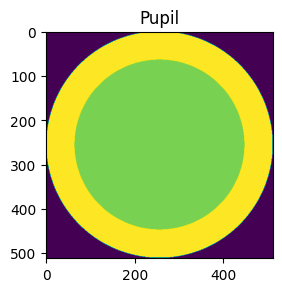

In [32]:
RES = 512    # Sizes of signals used here

def circle(radius=1.0):
    ii, jj = np.mgrid[-1:1:RES*1j, -1:1:RES*1j]
    ret = np.zeros([RES, RES])
    ret[np.sqrt(ii**2+jj**2)<radius] = 1.0
    return ret

pupil = circle(1.0)-circle(0.75)*0.2
plt.imshow(pupil), plt.title('Pupil');

Since our primary aplpication is diffraction integral calculation, our examples are in the same domain. Imagine, above is the pupil function discretized on ```RESxRES``` grid. Diffraction of this pupil funciton in the focal plane can be computed with FFT:

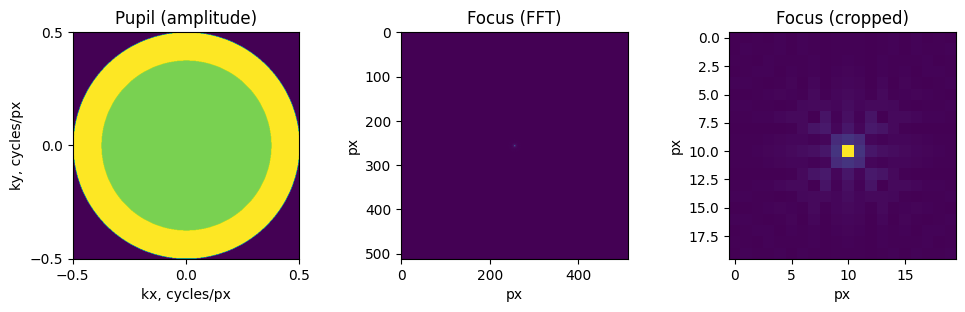

In [33]:
pupil = circle(1.0)-circle(0.75)*0.2
focal = np.fft.fftshift(np.fft.fft2(pupil))
P = 10
plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(pupil, extent=[-0.5,0.5,-0.5,0.5]), 
plt.xticks([-0.5, 0, 0.5]), plt.yticks([-0.5, 0, 0.5])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(132), plt.imshow(np.abs(focal)), plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (FFT)');
plt.subplot(133), plt.imshow(np.abs(focal)[RES//2-P:RES//2+P, RES//2-P:RES//2+P])
plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (cropped)');

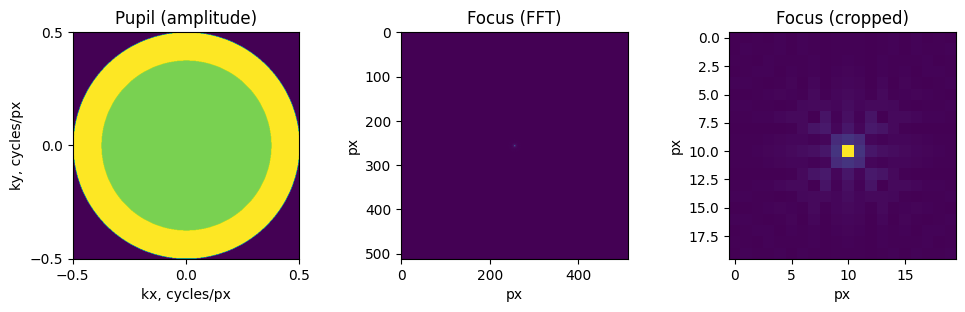

In [34]:
pupil = circle(1.0)-circle(0.75)*0.2
focal = np.fft.fftshift(np.fft.fft2(pupil))
P = 10
plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(pupil, extent=[-0.5,0.5,-0.5,0.5]), 
plt.xticks([-0.5, 0, 0.5]), plt.yticks([-0.5, 0, 0.5])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(132), plt.imshow(np.abs(focal)), plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (FFT)');
plt.subplot(133), plt.imshow(np.abs(focal)[RES//2-P:RES//2+P, RES//2-P:RES//2+P])
plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (cropped)');

As you can see above, the PSF is badly resolved, one one would expect to see an airy function, but its maximum is all located in a single central pixel.THis is because the pupil funciton has a lot of high frequencies. To 'zoom in' with FFT we would need to specify our pupil function across lowere frequency band, or simply scale it down (in k-space the further from origin - the higher the frequency, and _lower_ frequencies render _bigger_ objects):

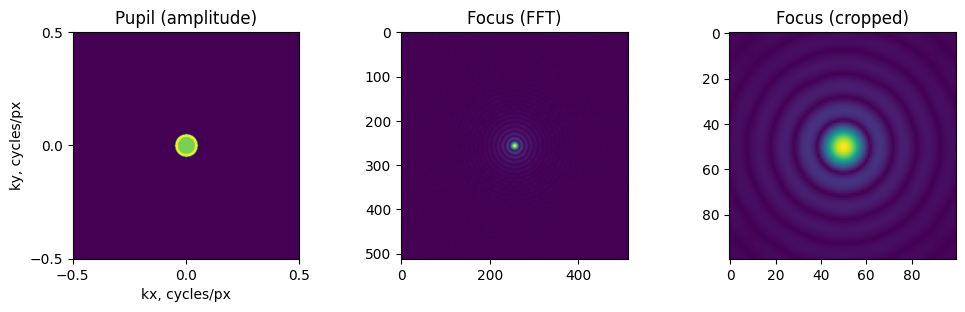

In [35]:
s = 0.1
pupil = circle(1.0*s)-circle(0.75*s)*0.2
focal = np.fft.fftshift(np.fft.fft2(pupil))
P = 50
plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(pupil, extent=[-0.5,0.5,-0.5,0.5]);
plt.xticks([-0.5, 0, 0.5]), plt.yticks([-0.5, 0, 0.5])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(132), plt.imshow(np.abs(focal)), plt.title('Focus (FFT)');
plt.subplot(133), plt.imshow(np.abs(focal)[RES//2-P:RES//2+P, RES//2-P:RES//2+P]), plt.title('Focus (cropped)');

Now we get what is needed, however at colst of lower resolution in the pupil function. If even bigger zoom-in is needed the pupil function will no longer be correctly resolved, resulting in deformed focus, as some lateral frequencies would be lost: 

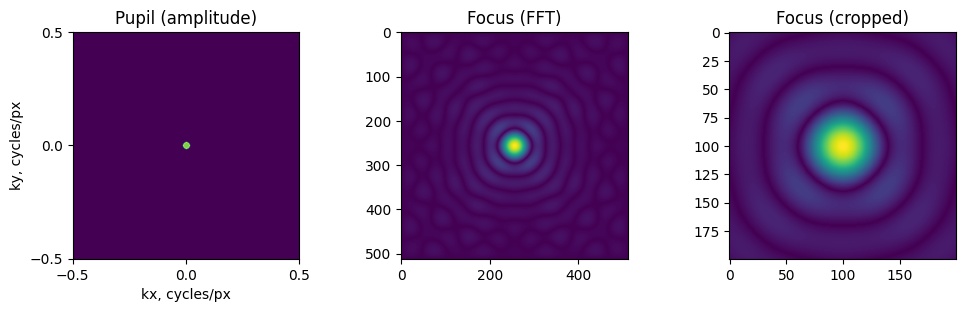

In [36]:
s = 0.03
pupil = circle(1.0*s)-circle(0.75*s)*0.2
focal = np.fft.fftshift(np.fft.fft2(pupil))
P = 100
plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(pupil, extent=[-0.5,0.5,-0.5,0.5]);
plt.xticks([-0.5, 0, 0.5]), plt.yticks([-0.5, 0, 0.5])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(132), plt.imshow(np.abs(focal)), plt.title('Focus (FFT)');
plt.subplot(133), plt.imshow(np.abs(focal)[RES//2-P:RES//2+P, RES//2-P:RES//2+P]), plt.title('Focus (cropped)');

This is an issue for modelling of microscope PSF, where pupil resolution is important (phase aberration needs to be resolved fulfilling the sampling condition, limiting maximal phase jumps between adjacent points to under Pi).

**One possible solution** is to zero-pad the FFT input and then crop:

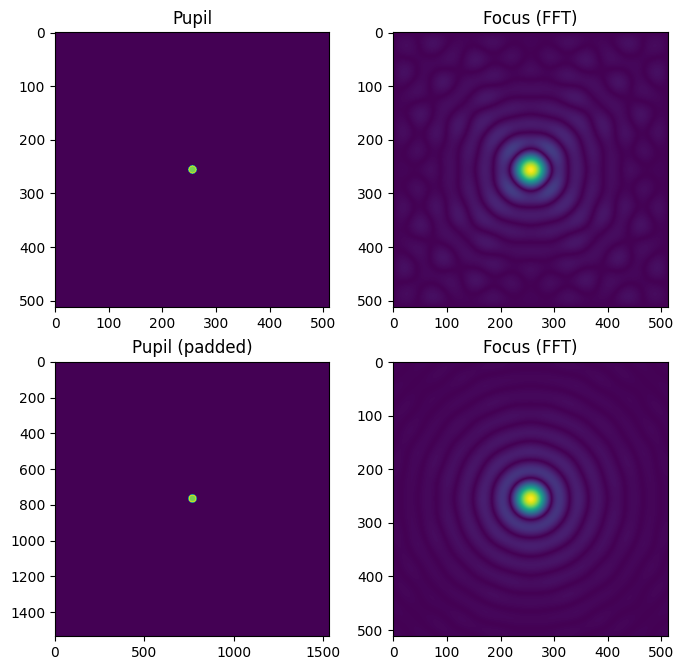

In [37]:
s = 0.03
pupil = circle(1.0*s)-circle(0.75*s)*0.2
plt.figure(figsize=(8,8))
plt.subplot(221), plt.imshow(pupil), plt.title('Pupil')
focal = np.fft.fftshift(np.fft.fft2(pupil))
plt.subplot(222), plt.imshow(np.abs(focal)), plt.title('Focus (FFT)')
s = 0.03*3
pupil = circle(1.0*s)-circle(0.75*s)*0.2
pupil = np.pad(pupil, RES)
plt.subplot(223), plt.imshow(pupil), plt.title('Pupil (padded)')
focal = np.fft.fftshift(np.fft.fft2(pupil))[RES:-RES, RES:-RES]
plt.subplot(224), plt.imshow(np.abs(focal)), plt.title('Focus (FFT)');

This minor improvement had a big cost, here input was scaled x3 times in each dimension. For typical scales needed for microscope simulation this will cost large overhead, and most of the k-space stays empty anyways.

### Better solution:
Change the frequency band of the input keeping the resolution the same. Unlike FFT, CZT allows that:

Instantitaing CZT with float32 (complex64) floating point precision.
Using L=1024. You may suggest a better value for performance.
Instantitaing CZT with float32 (complex64) floating point precision.
Using L=1024. You may suggest a better value for performance.


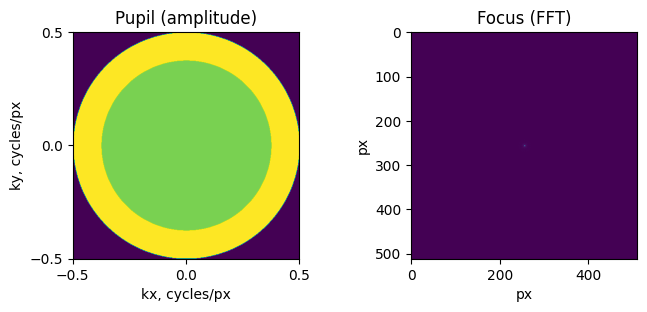

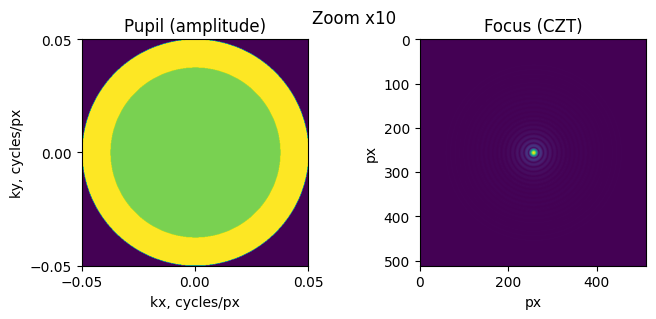

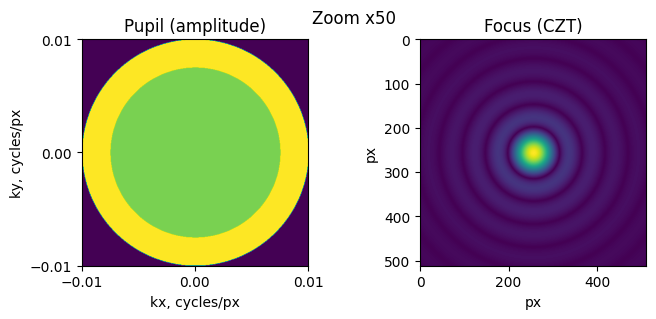

In [38]:
pupil = circle(1.0)-circle(0.75)*0.2
focal = np.fft.fftshift(np.fft.fft2(pupil))
P = 10
plt.figure(figsize=(8,3))
plt.subplot(121), plt.imshow(pupil, extent=[-0.5,0.5,-0.5,0.5]), 
plt.xticks([-0.5, 0, 0.5]), plt.yticks([-0.5, 0, 0.5])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(122), plt.imshow(np.abs(focal)), plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (FFT)');

zoom = 10
w_begin=-0.5/zoom
w_end=0.5/zoom
pupil = circle(1.0)-circle(0.75)*0.2
focal = czt2d(pupil, czt_factors(RES, RES, w_begin=w_begin, w_end=w_end))
plt.figure(figsize=(8,3))
plt.suptitle(f'Zoom x{zoom}');
plt.subplot(121), plt.imshow(pupil, extent=[w_begin, w_end, w_begin, w_end]), 
plt.xticks([w_begin, 0, w_end]), plt.yticks([w_begin, 0, w_end])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(122), plt.imshow(np.abs(focal)), plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (CZT)');


zoom = 50
w_begin=-0.5/zoom
w_end=0.5/zoom
pupil = circle(1.0)-circle(0.75)*0.2
focal = czt2d(pupil, czt_factors(RES, RES, w_begin=w_begin, w_end=w_end))
plt.figure(figsize=(8,3))
plt.suptitle(f'Zoom x{zoom}');
plt.subplot(121), plt.imshow(pupil, extent=[w_begin, w_end, w_begin, w_end]), 
plt.xticks([w_begin, 0, w_end]), plt.yticks([w_begin, 0, w_end])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(122), plt.imshow(np.abs(focal)), plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (CZT)');


Additionally CZT allows to change the output resolution which may be useful in some situations:

Instantitaing CZT with float32 (complex64) floating point precision.
Using L=576. You may suggest a better value for performance.
Instantitaing CZT with float32 (complex64) floating point precision.
Using L=544. You may suggest a better value for performance.


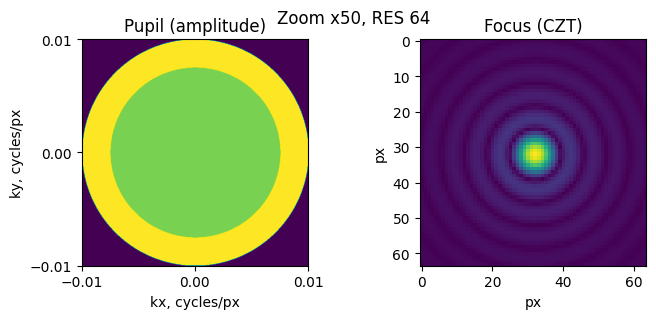

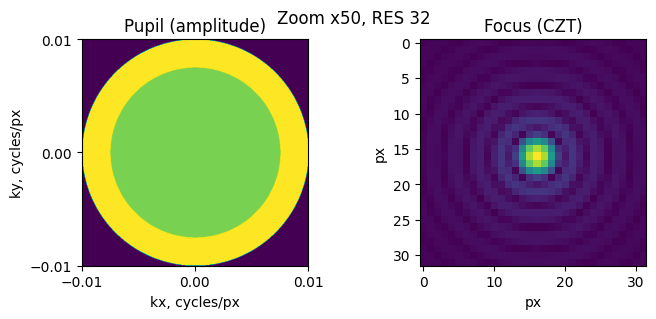

In [39]:
zoom = 50
out_res = 64
w_begin=-0.5/zoom
w_end=0.5/zoom
pupil = circle(1.0)-circle(0.75)*0.2
focal = czt2d(pupil, czt_factors(RES, out_res, w_begin=w_begin, w_end=w_end))
plt.figure(figsize=(8,3))
plt.suptitle(f'Zoom x{zoom}, RES {out_res}');
plt.subplot(121), plt.imshow(pupil, extent=[w_begin, w_end, w_begin, w_end]), 
plt.xticks([w_begin, 0, w_end]), plt.yticks([w_begin, 0, w_end])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(122), plt.imshow(np.abs(focal)), plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (CZT)');


zoom = 50
out_res = 32
w_begin=-0.5/zoom
w_end=0.5/zoom
pupil = circle(1.0)-circle(0.75)*0.2
focal = czt2d(pupil, czt_factors(RES, out_res, w_begin=w_begin, w_end=w_end))
plt.figure(figsize=(8,3))
plt.suptitle(f'Zoom x{zoom}, RES {out_res}');
plt.subplot(121), plt.imshow(pupil, extent=[w_begin, w_end, w_begin, w_end]), 
plt.xticks([w_begin, 0, w_end]), plt.yticks([w_begin, 0, w_end])
plt.xlabel('kx, cycles/px'), plt.ylabel('ky, cycles/px'), plt.title('Pupil (amplitude)')
plt.subplot(122), plt.imshow(np.abs(focal)), plt.xlabel('px'), plt.ylabel('px'), plt.title('Focus (CZT)');

# Usage

The CZT algorithm utilizes 2 FFTs and constant factors multiplications. For optimization we separated the constant factors precalculation, as they can be reused as long as transform parameters (scale and resolution) stay the same:

Generating Zernikes on uniform grid...
Instantitaing CZT with float32 (complex64) floating point precision.
Using L=1024. You may suggest a better value for performance.


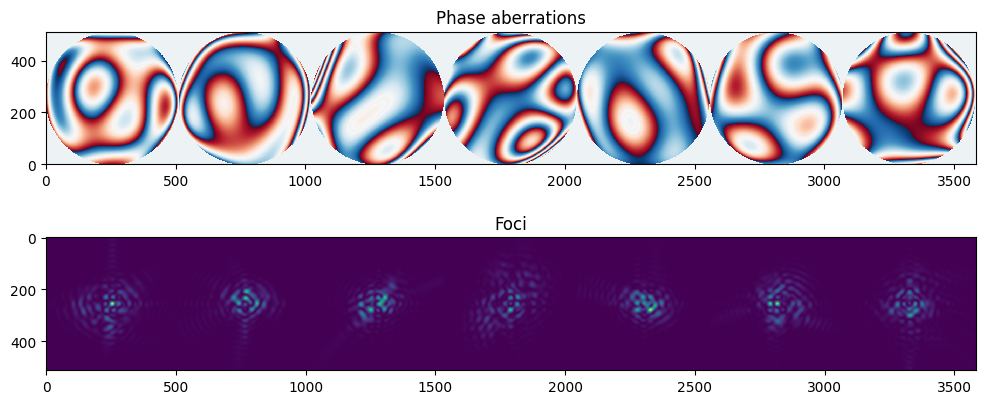

In [40]:
from wavefronts import Zernike

RES = 512

aperture = circle(radius=1.0)
zernike = Zernike(resolution=RES)
pupils = []
for _ in range(10):
    phase = zernike.phase(np.random.randn(20))*0.1
    pupil = aperture*np.exp(1j*(phase))
    pupil[zernike.mask<0.5] = -1 # this is to keep background white in the colormap used
    pupils.append(pupil)


# using czt2d transform:
cf = czt_factors(RES, RES, -0.5/20, 0.5/20)
foci = czt2d(np.stack(pupils, 0), cf)
foci = np.abs(foci)**2


plt.figure(figsize=(12,5))
plt.subplot(211)
plt.pcolormesh(np.hstack(np.angle(pupils)[:7])%6, cmap='RdBu'); plt.title('Phase aberrations')
plt.gca().set_aspect('equal');
plt.subplot(212)
plt.imshow(np.hstack(foci[:7])); plt.title('Foci');